This tutorial is modified from https://www.kaggle.com/rkuo2000/ecg-classification/comments#778183

Model design based on ECG Heartbeat Classification: [A Deep Transferable Representation](https://arxiv.org/pdf/1805.00794.pdf) 

In [1]:
#@title Show GPU infomation
!nvidia-smi

Thu Apr  2 09:59:05 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
#@title Download [ECG Heartbeat Categorization Dataset]
# https://www.kaggle.com/shayanfazeli/heartbeat
filename = 'heartbeat.zip'
!wget -O {filename} 'https://storage.googleapis.com/meso_patho/heartbeat.zip'
!unzip {filename}

--2020-04-02 09:59:15--  https://storage.googleapis.com/meso_patho/heartbeat.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.194.128, 2404:6800:4003:c04::80
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.194.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 103633768 (99M) [application/zip]
Saving to: ‘heartbeat.zip’

heartbeat.zip       100%[===================>]  98.83M   239MB/s    in 0.4s    

2020-04-02 09:59:15 (239 MB/s) - ‘heartbeat.zip’ saved [103633768/103633768]

Archive:  heartbeat.zip
  inflating: mitbih_test.csv         
  inflating: mitbih_train.csv        
  inflating: ptbdb_abnormal.csv      
  inflating: ptbdb_normal.csv        


# -- Import packages

In [0]:
import os
import math
import random
import pickle
import itertools
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.utils import shuffle
from scipy.signal import resample
from scipy import interp
from itertools import cycle, product
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Input, Dense, Conv1D, MaxPooling1D, Softmax, Add, Flatten, Activation, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.optimizers import Adam

# 1 Dataset

In [4]:
#@title load dataset
df = pd.read_csv("mitbih_train.csv", header=None)
df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,0.044118,0.061275,0.066176,0.061275,0.049020,0.073529,0.061275,0.061275,0.066176,0.068627,0.095588,0.075980,0.093137,0.105392,0.115196,0.102941,0.117647,0.125000,0.142157,0.127451,0.151961,0.144608,0.164216,0.144608,0.159314,0.151961,0.154412,0.142157,0.151961,0.151961,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,0.074074,0.062678,0.065527,0.065527,0.062678,0.076923,0.071225,0.082621,0.091168,0.096866,0.082621,0.082621,0.091168,0.105413,0.122507,0.148148,0.182336,0.193732,0.213675,0.207977,0.222222,0.253561,0.270655,0.287749,0.284900,0.293447,0.256410,0.247863,0.188034,0.145299,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,0.056757,0.043243,0.067568,0.062162,0.078378,0.072973,0.086486,0.081081,0.108108,0.110811,0.135135,0.135135,0.170270,0.183784,0.216216,0.237838,0.270270,0.286486,0.316216,0.318919,0.332432,0.297297,0.267568,0.216216,0.189189,0.132432,0.118919,0.064865,0.064865,0.043243,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,0.063536,0.082873,0.085635,0.093923,0.113260,0.124309,0.140884,0.132597,0.140884,0.091160,0.085635,0.074586,0.071823,0.080110,0.096685,0.118785,0.138122,0.140884,0.138122,0.146409,0.110497,0.102210,0.060773,0.027624,0.038674,0.013812,0.011050,0.013812,0.033149,0.005525,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,0.131455,0.122066,0.140845,0.159624,0.150235,0.145540,0.136150,0.169014,0.178404,0.173709,0.183099,0.201878,0.187793,0.164319,0.187793,0.215962,0.215962,0.201878,0.211268,0.230047,0.215962,0.230047,0.239437,0.267606,0.253521,0.230047,0.220657,0.225352,0.211268,0.173709,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
87549,0.807018,0.494737,0.536842,0.529825,0.491228,0.484211,0.456140,0.396491,0.284211,0.136842,0.052632,0.140351,0.119298,0.091228,0.140351,0.161404,0.105263,0.143860,0.143860,0.129825,0.147368,0.157895,0.164912,0.168421,0.154386,0.175439,0.164912,0.154386,0.182456,0.192982,0.196491,0.207018,0.217544,0.217544,0.256140,0.284211,0.294737,0.301754,0.301754,0.322807,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
87550,0.718333,0.605000,0.486667,0.361667,0.231667,0.120000,0.051667,0.001667,0.000000,0.013333,0.078333,0.183333,0.275000,0.315000,0.361667,0.430000,0.481667,0.526667,0.543333,0.563333,0.581667,0.588333,0.600000,0.603333,0.613333,0.6216

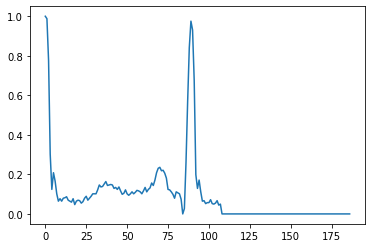

In [5]:
# show one data    # colume 187 is target label
idx = 1000
plt.plot(df.iloc[idx,:187])

In [6]:
#@title define dataset X and y
M = df.values  # numpy array M
X = M[:, :-1]  # column 0-186
y = M[:, -1].astype(int)  # # column 187
print("dataset X shape =", X.shape)
print("dataset y shape =", y.shape)

dataset X shape = (87554, 187)
dataset y shape = (87554,)


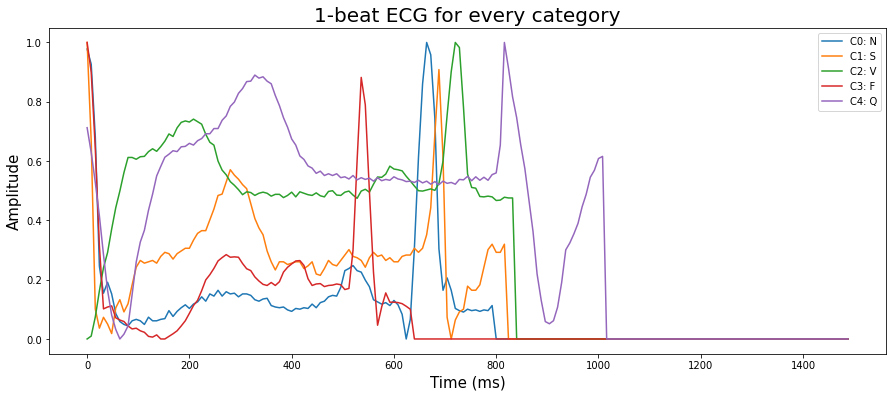

In [7]:
## visualize dataset X
C0_idx = np.argwhere(y==0).flatten()
C1_idx = np.argwhere(y==1).flatten()
C2_idx = np.argwhere(y==2).flatten()
C3_idx = np.argwhere(y==3).flatten()
C4_idx = np.argwhere(y==4).flatten()

t = np.arange(0, 187) * (1/125) * 1000  # time-line with Sampling Frequency: 125Hz

# plot
plt.figure(figsize=(15,6))
plt.plot(t, X[C0_idx, :][0], label="C0: N")
plt.plot(t, X[C1_idx, :][0], label="C1: S")
plt.plot(t, X[C2_idx, :][0], label="C2: V")
plt.plot(t, X[C3_idx, :][0], label="C3: F")
plt.plot(t, X[C4_idx, :][0], label="C4: Q")
plt.legend()
plt.title("1-beat ECG for every category", fontsize=20)
plt.ylabel("Amplitude", fontsize=15)
plt.xlabel("Time (ms)", fontsize=15)
plt.show()

number of each class: C0, C1, C2, C3, C4 = [72471, 2223, 5788, 641, 6431]


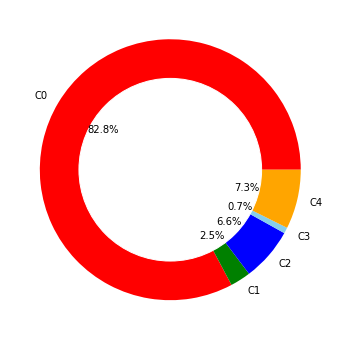

In [8]:
# show number of each class
class_num = [ C0_idx.shape[0], C1_idx.shape[0], C2_idx.shape[0], C3_idx.shape[0], C4_idx.shape[0]]
print("number of each class: C0, C1, C2, C3, C4 =", class_num)

# plot the circle of class counts
plt.figure(figsize=(6,6))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(class_num, labels=['C0','C1','C2','C3','C4'], colors=['red','green','blue','skyblue','orange'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

## split dataset to training_set and valid_set

In [9]:
# train_test_split (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
val_set_ratio = 0.2
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=val_set_ratio, random_state=42)

# set channel last
X_train = np.expand_dims(X_train, 2)  # as shape (number_of_data, X_lengh, 1-channel)
X_val = np.expand_dims(X_val, 2)  # as shape (number_of_data, X_lengh, 1-channel)

print("class count train : (C0:", X_train[np.argwhere(y_train==0)].shape[0], ", C1:", X_train[np.argwhere(y_train==1)].shape[0], ", C2:", X_train[np.argwhere(y_train==2)].shape[0], ", C3:", X_train[np.argwhere(y_train==3)].shape[0], ", C4:", X_train[np.argwhere(y_train==4)].shape[0], ")")
print("class count val   : (C0:", X_val[np.argwhere(y_val==0)].shape[0], ", C1:", X_val[np.argwhere(y_val==1)].shape[0], ", C2:", X_val[np.argwhere(y_val==2)].shape[0], ", C3:", X_val[np.argwhere(y_val==3)].shape[0], ", C4:", X_val[np.argwhere(y_val==4)].shape[0], ")")
print("X_train shape =", X_train.shape)
print("y_train shape =", y_train.shape)
print("X_val shape =", X_val.shape)
print("y_val shape =", y_val.shape)

class count train : (C0: 57892 , C1: 1797 , C2: 4676 , C3: 496 , C4: 5182 )
class count val   : (C0: 14579 , C1: 426 , C2: 1112 , C3: 145 , C4: 1249 )
X_train shape = (70043, 187, 1)
y_train shape = (70043,)
X_val shape = (17511, 187, 1)
y_val shape = (17511,)


## balance dataset via augmentation

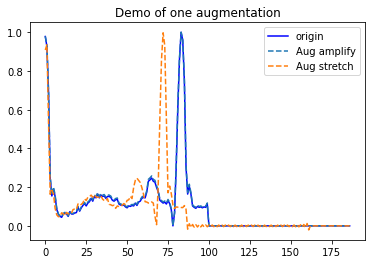

In [10]:
def stretch(x):
    l = int(187 * (1 + (random.random()-0.5)/3))
    y = resample(x, l)
    if l < 187:
        y_ = np.zeros(shape=(187, ))
        y_[:l] = y
    else:
        y_ = y[:187]
    return y_

def amplify(x):
    alpha = (random.random()-0.5)
    factor = -alpha*x + (1+alpha)
    return x*factor

def augment(x):
    # 4 times augmentation
    result = np.zeros(shape= (4, 187))
    for i in range(3):
        if random.random() < 0.33:
            new_x = stretch(x)
        elif random.random() < 0.66:
            new_x = amplify(x)
        else:
            new_x = stretch(x)
            new_x = amplify(new_x)
        result[i, :] = new_x
    return result

plt.title("Demo of one augmentation")
plt.plot(X[0, :], 'b', label="origin")
plt.plot(amplify(X[0, :]), '--', label="Aug amplify")
plt.plot(stretch(X[0, :]), '--', label="Aug stretch")
plt.legend()
plt.show()

In [11]:
print("before augmentation:")
print("class count train : (C0:", X_train[np.argwhere(y_train==0)].shape[0], ", C1:", X_train[np.argwhere(y_train==1)].shape[0], ", C2:", X_train[np.argwhere(y_train==2)].shape[0], ", C3:", X_train[np.argwhere(y_train==3)].shape[0], ", C4:", X_train[np.argwhere(y_train==4)].shape[0], ")")
print("class count val   : (C0:", X_val[np.argwhere(y_val==0)].shape[0], ", C1:", X_val[np.argwhere(y_val==1)].shape[0], ", C2:", X_val[np.argwhere(y_val==2)].shape[0], ", C3:", X_val[np.argwhere(y_val==3)].shape[0], ", C4:", X_val[np.argwhere(y_val==4)].shape[0], ")")

before augmentation:
class count train : (C0: 57892 , C1: 1797 , C2: 4676 , C3: 496 , C4: 5182 )
class count val   : (C0: 14579 , C1: 426 , C2: 1112 , C3: 145 , C4: 1249 )


In [12]:
#@title apply augmentation

# augment C3 5 times
def augment_C3(X, y):
    C3_idx = np.argwhere(y==3).flatten()
    result = np.apply_along_axis(augment, axis=1, arr=X[C3_idx]).reshape(-1, 187, 1)
    classe = np.ones(shape=(result.shape[0],), dtype=int)*3
    # append aug_data to training dataset
    X = np.vstack([X, result])
    y = np.hstack([y, classe])
    return X, y

X_train, y_train = augment_C3(X_train, y_train)
X_val, y_val = augment_C3(X_val, y_val)

print("after augmentation:")
print("class count train : (C0:", X_train[np.argwhere(y_train==0)].shape[0], ", C1:", X_train[np.argwhere(y_train==1)].shape[0], ", C2:", X_train[np.argwhere(y_train==2)].shape[0], ", C3:", X_train[np.argwhere(y_train==3)].shape[0], ", C4:", X_train[np.argwhere(y_train==4)].shape[0], ")")
print("class count val   : (C0:", X_val[np.argwhere(y_val==0)].shape[0], ", C1:", X_val[np.argwhere(y_val==1)].shape[0], ", C2:", X_val[np.argwhere(y_val==2)].shape[0], ", C3:", X_val[np.argwhere(y_val==3)].shape[0], ", C4:", X_val[np.argwhere(y_val==4)].shape[0], ")")

after augmentation:
class count train : (C0: 57892 , C1: 1797 , C2: 4676 , C3: 2480 , C4: 5182 )
class count val   : (C0: 14579 , C1: 426 , C2: 1112 , C3: 725 , C4: 1249 )


## shuffle data

In [13]:
print("Before shuffle, y_val[:30] =", y_val[:30])

X_train, y_train = shuffle(X_train, y_train, random_state=0)
X_val, y_val = shuffle(X_val, y_val, random_state=0)

print("After  shuffle, y_val[:30] =", y_val[:30])

Before shuffle, y_val[:30] = [0 0 0 0 4 0 0 4 4 0 0 0 0 0 0 0 1 0 0 0 4 0 0 0 0 0 2 2 4 0]
After  shuffle, y_val[:30] = [4 0 0 0 0 0 0 0 1 4 1 0 4 4 0 0 2 0 0 2 0 0 0 3 0 0 0 0 2 4]


## one-hot encoding y
https://www.tensorflow.org/api_docs/python/tf/keras/utils/to_categorical

In [14]:
print("Before one-hot encoding y_train[0] =", y_train[0])

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)

print("After one-hot encoding y_train[0] =", y_train[0])
print("y_train shape =", y_train.shape)
print("y_val shape =", y_val.shape)

Before one-hot encoding y_train[0] = 0
After one-hot encoding y_train[0] = [1. 0. 0. 0. 0.]
y_train shape = (72027, 5)
y_val shape = (18091, 5)


# 2 Model
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential
https://keras.io/layers/about-keras-layers/

In [16]:
#@title build model with Keras Sequential-API
# https://keras.io/models/sequential/

# check Input shape
n_obs, feature, depth = X_train.shape
print(f"Input shape = ({feature}, {depth})")

model = Sequential()
model.add(Input(shape=(feature, depth)))
model.add(Conv1D(filters=32, kernel_size=3, strides=1))
model.add(Dense(32, activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=5, strides=2))
model.add(Dropout(0.25))

model.add(Dense(32, activation='relu'))
model.add(Activation('relu'))
model.add(MaxPooling1D(pool_size=5, strides=2))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(5,activation='softmax'))
model.summary()

Input shape = (187, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 185, 32)           128       
_________________________________________________________________
dense_2 (Dense)              (None, 185, 32)           1056      
_________________________________________________________________
activation_1 (Activation)    (None, 185, 32)           0         
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 91, 32)            0         
_________________________________________________________________
dropout (Dropout)            (None, 91, 32)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 91, 32)            1056      
_________________________________________________________________
activation_2 (Activation)    (N

In [0]:
#@title build paper model with Keras Functional-API (disable)
# n_obs, feature, depth = X_train.shape

# inp = Input(shape=(feature, depth))
# C = Conv1D(filters=32, kernel_size=5, strides=1)(inp)

# C11 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(C)
# A11 = Activation("relu")(C11)
# C12 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A11)
# S11 = Add()([C12, C])
# A12 = Activation("relu")(S11)
# M11 = MaxPooling1D(pool_size=5, strides=2)(A12)

# C21 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M11)
# A21 = Activation("relu")(C21)
# C22 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A21)
# S21 = Add()([C22, M11])
# A22 = Activation("relu")(S11)
# M21 = MaxPooling1D(pool_size=5, strides=2)(A22)

# C31 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M21)
# A31 = Activation("relu")(C31)
# C32 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A31)
# S31 = Add()([C32, M21])
# A32 = Activation("relu")(S31)
# M31 = MaxPooling1D(pool_size=5, strides=2)(A32)

# C41 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M31)
# A41 = Activation("relu")(C41)
# C42 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A41)
# S41 = Add()([C42, M31])
# A42 = Activation("relu")(S41)
# M41 = MaxPooling1D(pool_size=5, strides=2)(A42)

# C51 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(M41)
# A51 = Activation("relu")(C51)
# C52 = Conv1D(filters=32, kernel_size=5, strides=1, padding='same')(A51)
# S51 = Add()([C52, M41])
# A52 = Activation("relu")(S51)
# M51 = MaxPooling1D(pool_size=5, strides=2)(A52)

# F1 = Flatten()(M51)

# D1 = Dense(32)(F1)
# A6 = Activation("relu")(D1)
# D2 = Dense(32)(A6)
# D3 = Dense(5)(D2)
# A7 = Softmax()(D3)

# model = Model(inputs=inp, outputs=A7)
# model.summary()

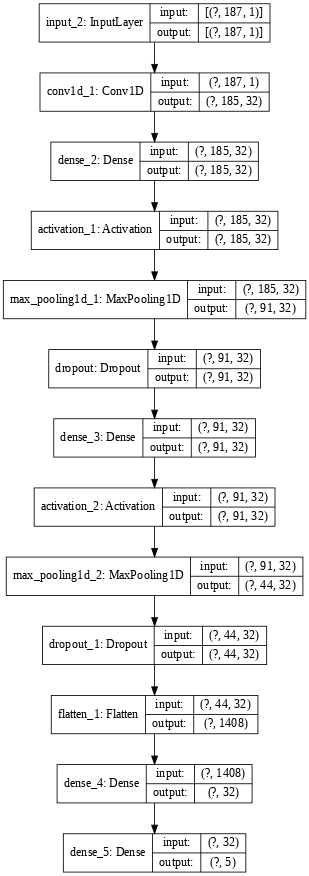

In [18]:
#@title plot model
plot_model(model, to_file="model_plot.png", show_shapes=True, dpi=60)

In [0]:
#@title Compile Model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

# 3 Train

In [0]:
# hyper parameters
batch_size = 100
num_epochs = 10

In [21]:
#@title start training model
history = model.fit(X_train, y_train, 
                    epochs=num_epochs, 
                    batch_size=batch_size, 
                    validation_data=(X_val, y_val), 
                    shuffle=True)

Epoch 1/10
721/721 [==============================] - 4s 5ms/step - loss: 0.4005 - accuracy: 0.8816 - val_loss: 0.2446 - val_accuracy: 0.9301
Epoch 2/10
721/721 [==============================] - 3s 5ms/step - loss: 0.2523 - accuracy: 0.9294 - val_loss: 0.2147 - val_accuracy: 0.9383
Epoch 3/10
721/721 [==============================] - 4s 5ms/step - loss: 0.2205 - accuracy: 0.9368 - val_loss: 0.1918 - val_accuracy: 0.9449
Epoch 4/10
721/721 [==============================] - 4s 5ms/step - loss: 0.2012 - accuracy: 0.9420 - val_loss: 0.1791 - val_accuracy: 0.9479
Epoch 5/10
721/721 [==============================] - 4s 5ms/step - loss: 0.1817 - accuracy: 0.9476 - val_loss: 0.1636 - val_accuracy: 0.9537
Epoch 6/10
721/721 [==============================] - 4s 5ms/step - loss: 0.1684 - accuracy: 0.9520 - val_loss: 0.1492 - val_accuracy: 0.9598
Epoch 7/10
721/721 [==============================] - 4s 5ms/step - loss: 0.1583 - accuracy: 0.9549 - val_loss: 0.1474 - val_accuracy: 0.9594
Epoch 

In [22]:
# The history.history attribute is a dictionary
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

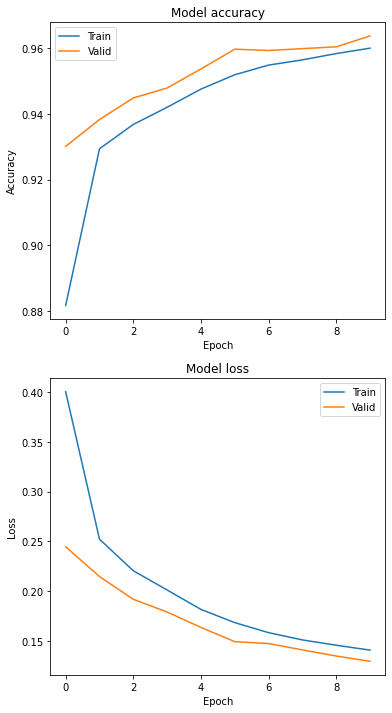

In [23]:
#@title Training history visualization
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,12))

# Plot training & validation accuracy values
ax1.plot(history.history['accuracy'])  # fix
ax1.plot(history.history['val_accuracy'])  # fix
ax1.set_title('Model accuracy')
ax1.set(ylabel='Accuracy', xlabel='Epoch')
ax1.legend(['Train', 'Valid'], loc='upper left')

# Plot training & validation loss values
ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('Model loss')
ax2.set(ylabel='Loss', xlabel='Epoch')
ax2.legend(['Train', 'Valid'], loc='upper right')

plt.savefig('train_history.png', dpi=72)  # <-- save plot
plt.show()

In [0]:
#@title save model
model.save("ecg_arrhythmia.h5")

In [25]:
#@title evaluate model with valid_set
loss, acc = model.evaluate(X_val,  y_val, verbose=2)
print("Valid_set accuracy: {:5.2f}%".format(100*acc))

566/566 - 2s - loss: 0.1294 - accuracy: 0.9638
Valid_set accuracy: 96.38%


# 4 Test

In [26]:
#@title Prepare test data
CLASSES = ['C0', 'C1', 'C2', 'C3', 'C4']

df2 = pd.read_csv("mitbih_test.csv", header=None)
M = df2.values  # numpy array M
X_test = M[:, :-1]
y_test = M[:, -1].astype(int)
X_test = np.expand_dims(X_test, 2)  # as shape (number_of_data, X_lengh, 1-channel)
y_test = to_categorical(y_test)  # one-hot encoding

print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

X_test: (21892, 187, 1)
y_test: (21892, 5)


In [27]:
#@title restore model
model = load_model('ecg_arrhythmia.h5')
model.trainable = False

In [28]:
#@title start inference model
y_pred = model.predict(X_test, batch_size=1000)
print("y_pred shape =", y_pred.shape)
y_pred

y_pred shape = (21892, 5)


array([[9.9948359e-01, 5.1464880e-04, 1.6488773e-06, 1.6517777e-08,
        1.0626227e-07],
       [8.5623783e-01, 1.6322631e-02, 8.2848430e-02, 2.1115597e-02,
        2.3475502e-02],
       [9.8109818e-01, 1.2084187e-02, 8.2742896e-05, 5.4952270e-05,
        6.6800648e-03],
       ...,
       [3.2749113e-02, 1.0306094e-04, 1.5162174e-03, 5.7377645e-05,
        9.6557426e-01],
       [2.0448817e-03, 8.2969245e-06, 2.2281081e-05, 6.7120155e-08,
        9.9792445e-01],
       [1.4473643e-04, 2.8977860e-07, 1.7954616e-06, 3.4444675e-10,
        9.9985313e-01]], dtype=float32)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


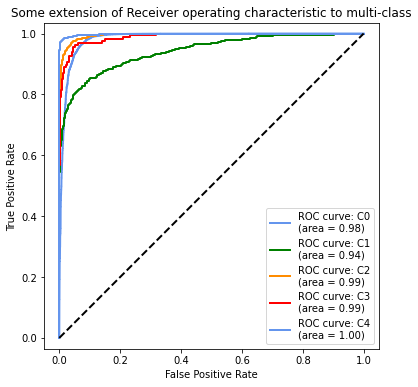

In [29]:
#@title plot ROC curve
#@title Compute ROC curve and ROC area for each class
N_CLASSES = len(CLASSES)
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(N_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute macro-average ROC curve and ROC area

lw = 2

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(N_CLASSES)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(N_CLASSES):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= N_CLASSES

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)

# plt.plot(fpr["micro"], tpr["micro"],
#          label='micro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["micro"]),
#          color='deeppink', linestyle=':', linewidth=4)

# plt.plot(fpr["macro"], tpr["macro"],
#          label='macro-average ROC curve (area = {0:0.2f})'
#                ''.format(roc_auc["macro"]),
#          color='navy', linestyle=':', linewidth=4)

colors = cycle(['cornflowerblue', 'green', 'darkorange', 'red'])
for i, color in zip(range(N_CLASSES), colors):
    ax.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve: {0}\n(area = {1:0.2f})'
             ''.format(CLASSES[i], roc_auc[i]))

ax.plot([0, 1], [0, 1], 'k--', lw=lw)
ax.set(xlim=(0.0, 1.0), ylim=(0.0, 1.0))
ax.axis('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('Some extension of Receiver operating characteristic to multi-class')
ax.legend(loc="lower right")
plt.show()

<Figure size 432x288 with 0 Axes>

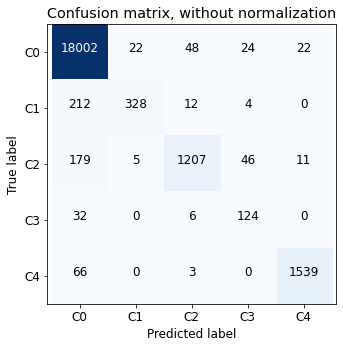

<Figure size 432x288 with 0 Axes>

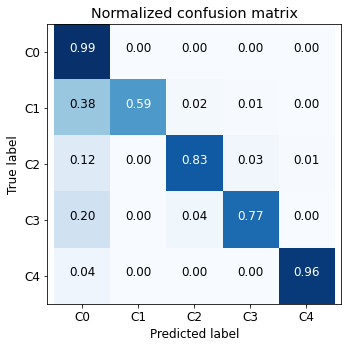

In [30]:
#@title plot confusion matrix
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html#sklearn.metrics.plot_confusion_matrix
class_names = CLASSES
plt.rcParams.update({'font.size': 12})

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
    else:
#         print('Confusion matrix, without normalization')
        pass

#     print(cm)

    fig = plt.figure(figsize=(5,5))
    ax = fig.add_subplot(111)
    ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.set_title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    ax.axis('equal')
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        ax.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    plt.tight_layout()

# Compute confusion matrix
cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [31]:
#@title classification report
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html?highlight=classification_report#sklearn.metrics.classification_report

print(classification_report(y_test.argmax(axis=1), y_pred.argmax(axis=1), target_names=CLASSES))

              precision    recall  f1-score   support

          C0       0.97      0.99      0.98     18118
          C1       0.92      0.59      0.72       556
          C2       0.95      0.83      0.89      1448
          C3       0.63      0.77      0.69       162
          C4       0.98      0.96      0.97      1608

    accuracy                           0.97     21892
   macro avg       0.89      0.83      0.85     21892
weighted avg       0.97      0.97      0.97     21892

